In [33]:
library(ggplot2)
library(readr)
library(dplyr)
library(lubridate)
library(tidyr)

In [32]:
install.packages("tidyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
system("git -C ../COVID-19/ pull")

In [34]:
deaths <- readr::read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
confirmed <- readr::read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
recovered <- readr::read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



In [180]:
melter <- function(df, var_name){
    df %>%
#     dplyr::select(-Lat, -Long) %>%
rename(region=`Country/Region`, province =`Province/State`) %>%
reshape2::melt(id.vars=c("region", "province", "Lat", "Long")) %>%    
tidyr::separate(col = province, into = c("city", "province"), sep = ",") %>% 
mutate(
    province = ifelse(is.na(province), city, province),
    province = trimws(ifelse(province %in% state.name, 
                      setNames(state.abb, state.name)[province],
                      province))
) %>%
transmute(
    region,
    province,
    city,
    lat=Lat,
    long=Long,
    ymd=mdy(variable),    
    value
) %>%
    rename_(.dots = setNames("value", var_name))
    
    
} 

In [192]:
pops <- read_csv('./census.csv')

Parsed with column specification:
cols(
  region = col_character(),
  pop = col_double()
)



In [181]:
deaths_df <- melter(deaths, "deaths")
recovered_df <- melter(recovered, "recovered")
confirmed_df <- melter(confirmed, "confirmed")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 8040 rows [6, 7, 8, 9, 20, 23, 50, 62, 72, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 8040 rows [6, 7, 8, 9, 20, 23, 50, 62, 72, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 8040 rows [6, 7, 8, 9, 20, 23, 50, 62, 72, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, ...].”


In [193]:
combined_df <- deaths_df %>%
left_join(recovered_df) %>%
left_join(confirmed_df) %>%
left_join(pops, by = c("province"="region"))

Joining, by = c("region", "province", "city", "lat", "long", "ymd")

Joining, by = c("region", "province", "city", "lat", "long", "ymd")



In [194]:
combined_df %>% sample_n(10)

region,province,city,lat,long,ymd,deaths,recovered,confirmed,pop
<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
US,GA,Fulton County,33.8034,-84.3963,2020-03-05,0,0,2,10617423
Brunei,NA,NA,4.5353,114.7277,2020-01-31,0,0,0,NA
Liechtenstein,NA,NA,47.1400,9.5500,2020-02-11,0,0,0,NA
US,WA,Thurston,46.8646,-122.7696,2020-01-29,0,0,0,7614893
US,CA,Stanislaus,37.5091,-120.9876,2020-02-08,0,0,0,39512223
Australia,New South Wales,New South Wales,-33.8688,151.2093,2020-03-20,6,4,353,NA
US,IN,Howard,40.4483,-86.1345,2020-02-19,0,0,0,6732219
US,IA,Pottawattamie,41.3912,-95.4778,2020-02-07,0,0,0,3155070
US,CA,Santa Cruz,37.0454,-121.9580,2020-03-10,0,0,0,39512223


In [195]:
options(repr.plot.width = 20, repr.plot.height = 8)

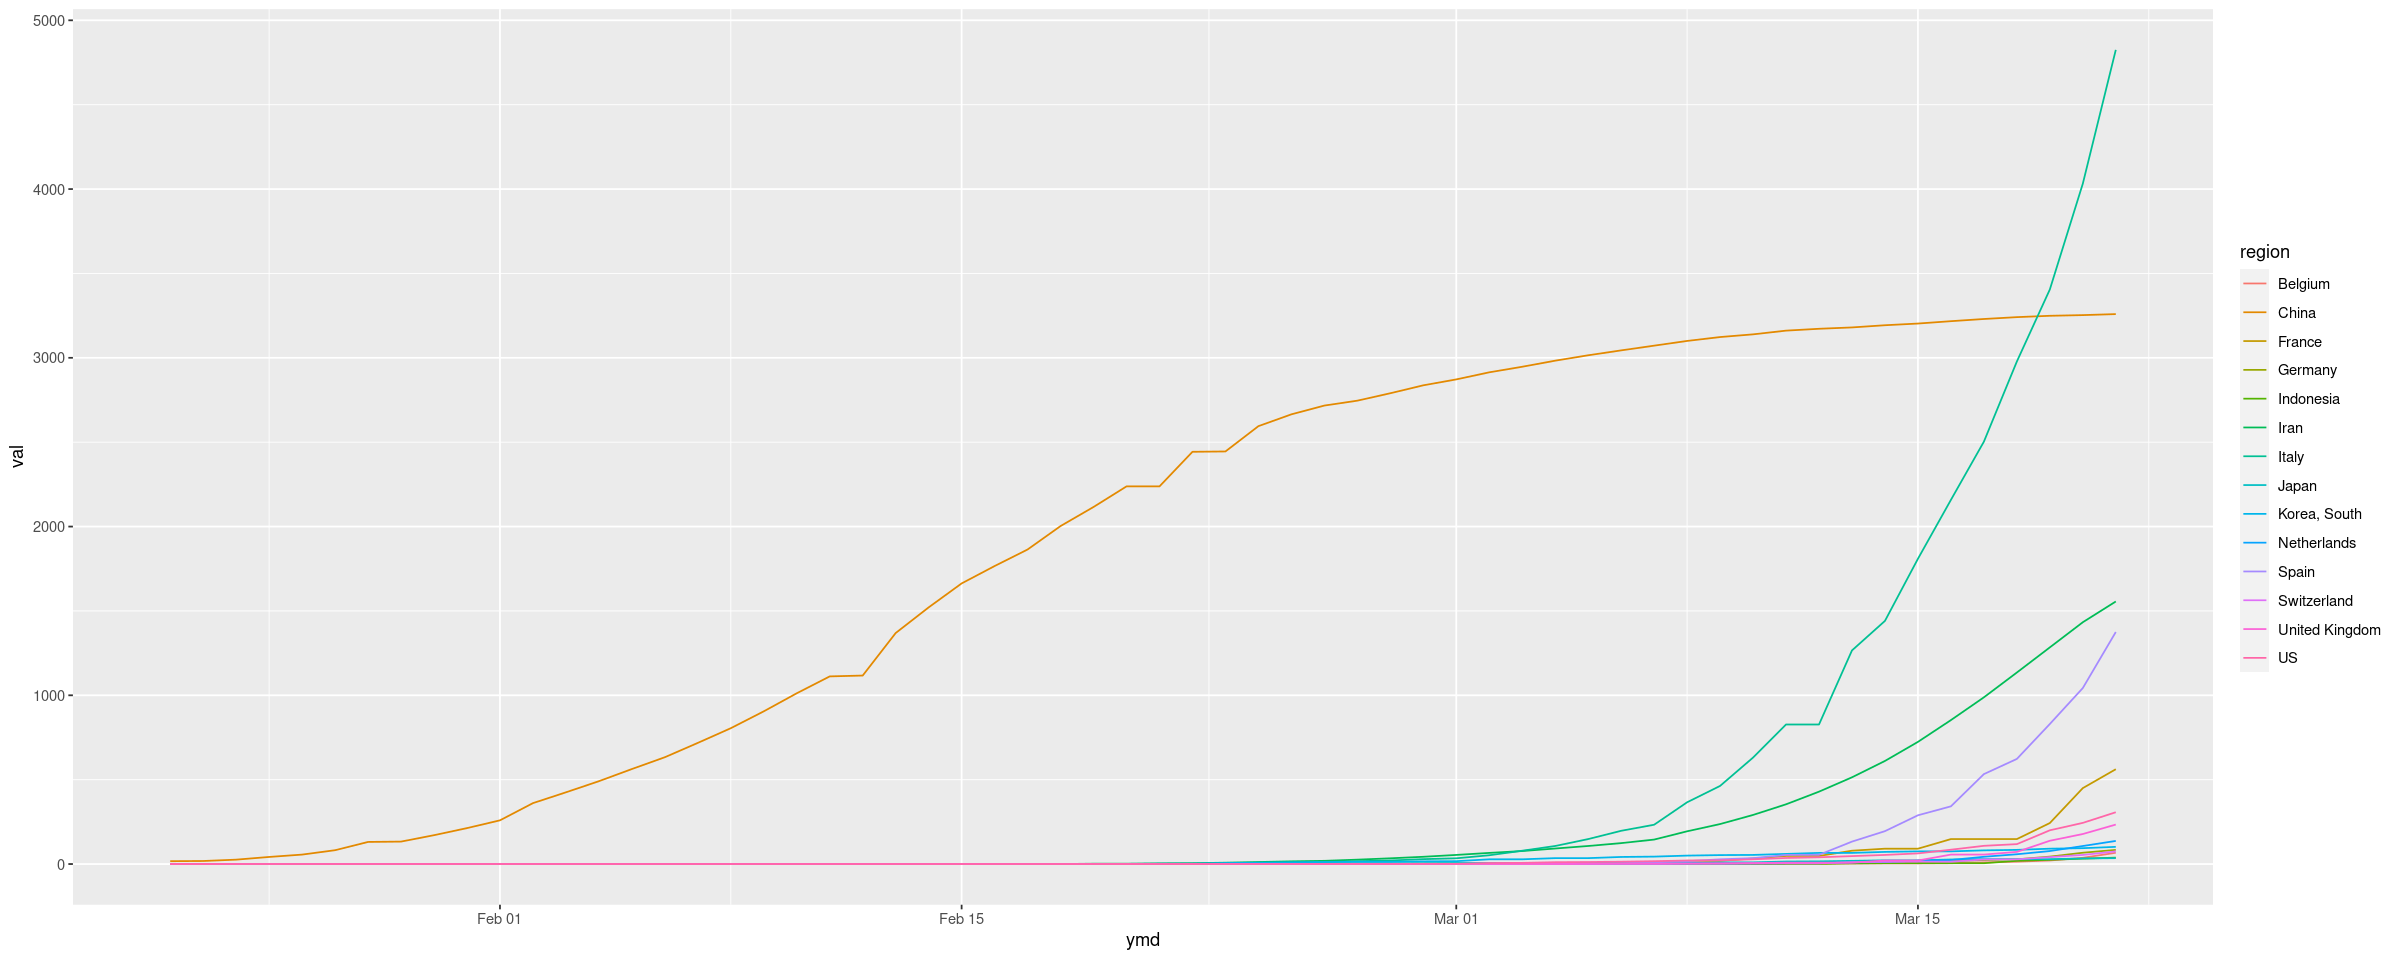

In [196]:
combined_df %>%
group_by(region, ymd) %>%
summarise(
    val = sum(deaths, na.rm = T)
) %>%
group_by(region) %>%
mutate(max_val= max(val)) %>%
ungroup() %>%
arrange(desc(max_val)) %>%
mutate(rank= dense_rank(desc(max_val)))%>%
filter(rank < 15) %>%
ggplot(aes(x=ymd, y= val, color=region)) +
geom_line()

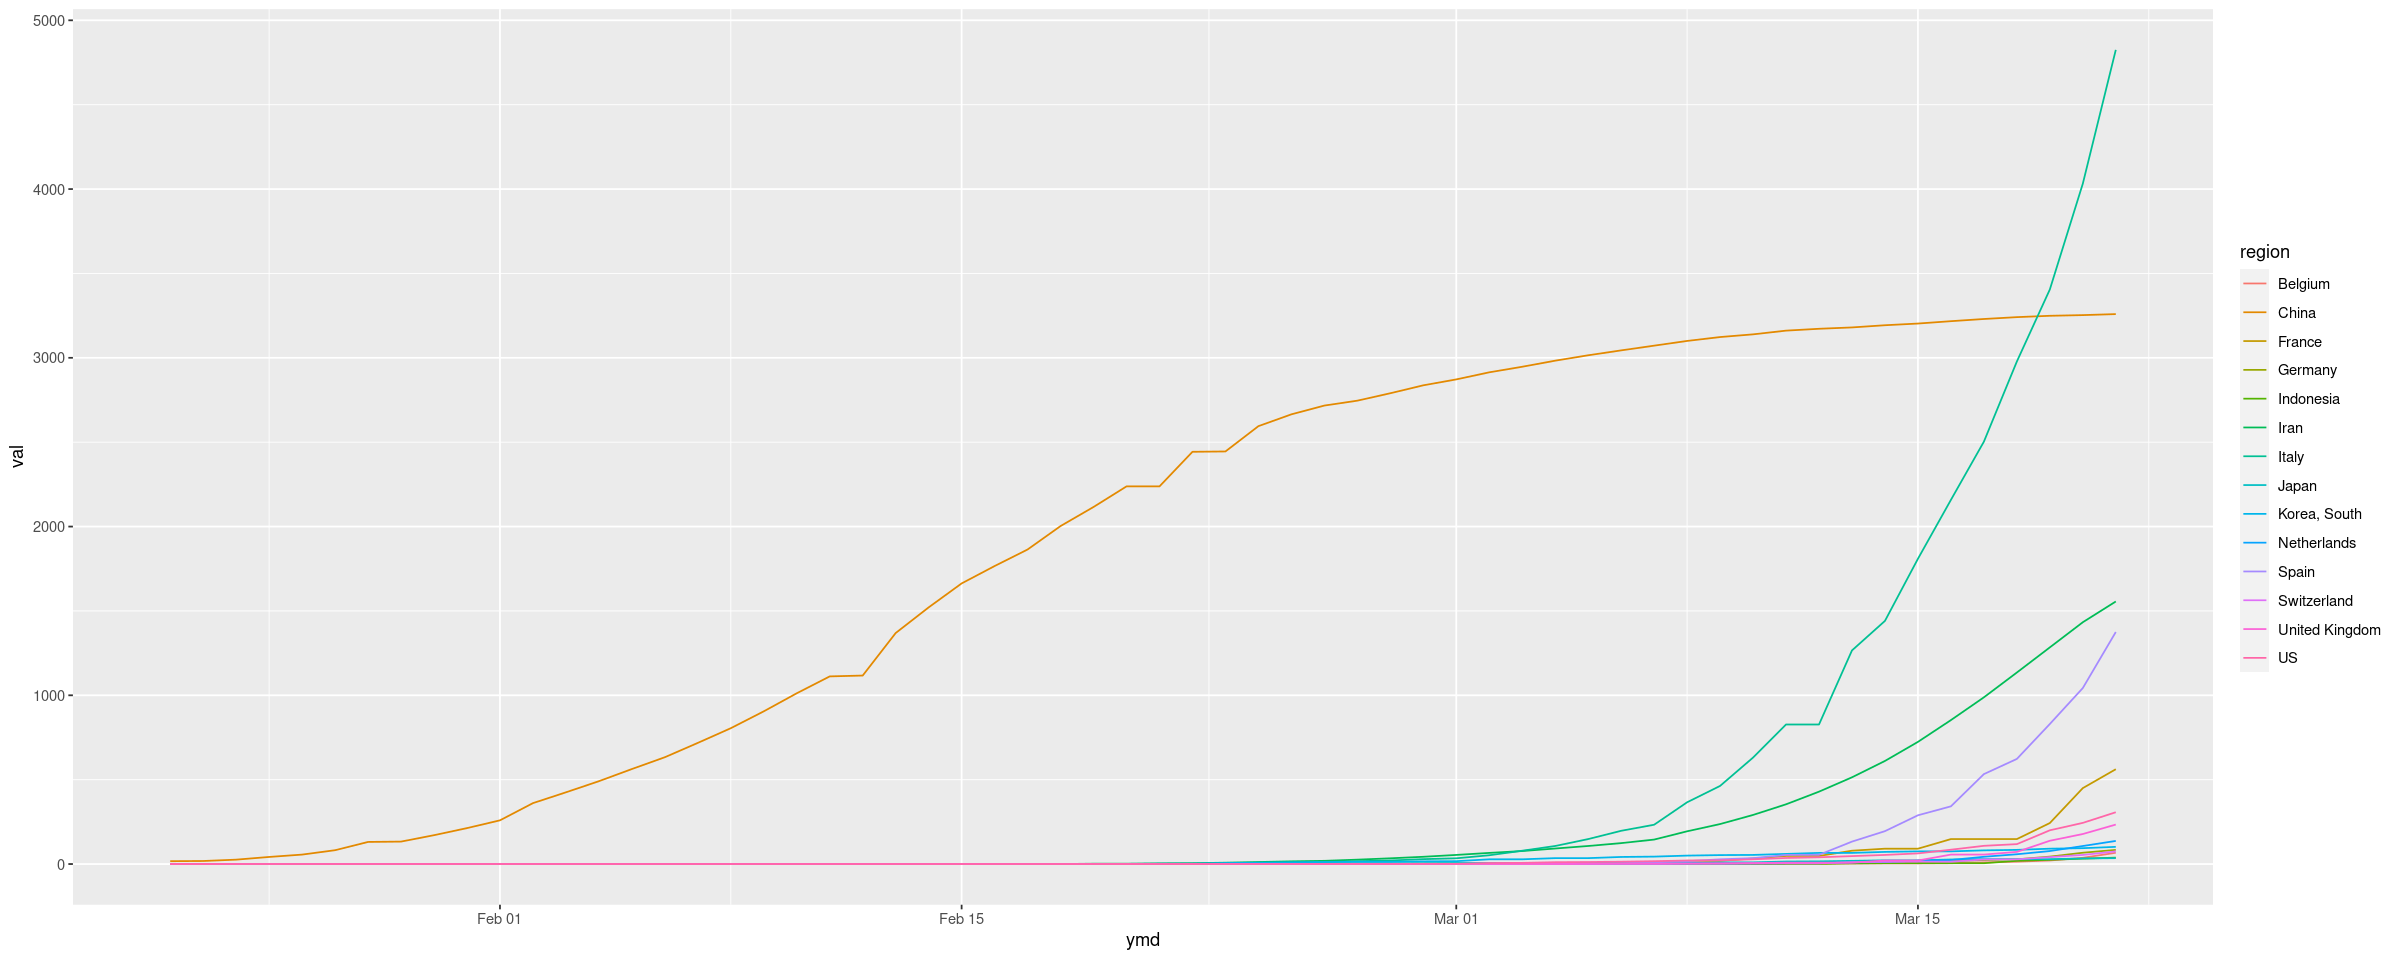

In [196]:
combined_df %>%
group_by(region, ymd) %>%
summarise(
    val = sum(deaths, na.rm = T)
) %>%
group_by(region) %>%
mutate(max_val= max(val)) %>%
ungroup() %>%
arrange(desc(max_val)) %>%
mutate(rank= dense_rank(desc(max_val)))%>%
filter(rank < 15) %>%
ggplot(aes(x=ymd, y= val, color=region)) +
geom_line()

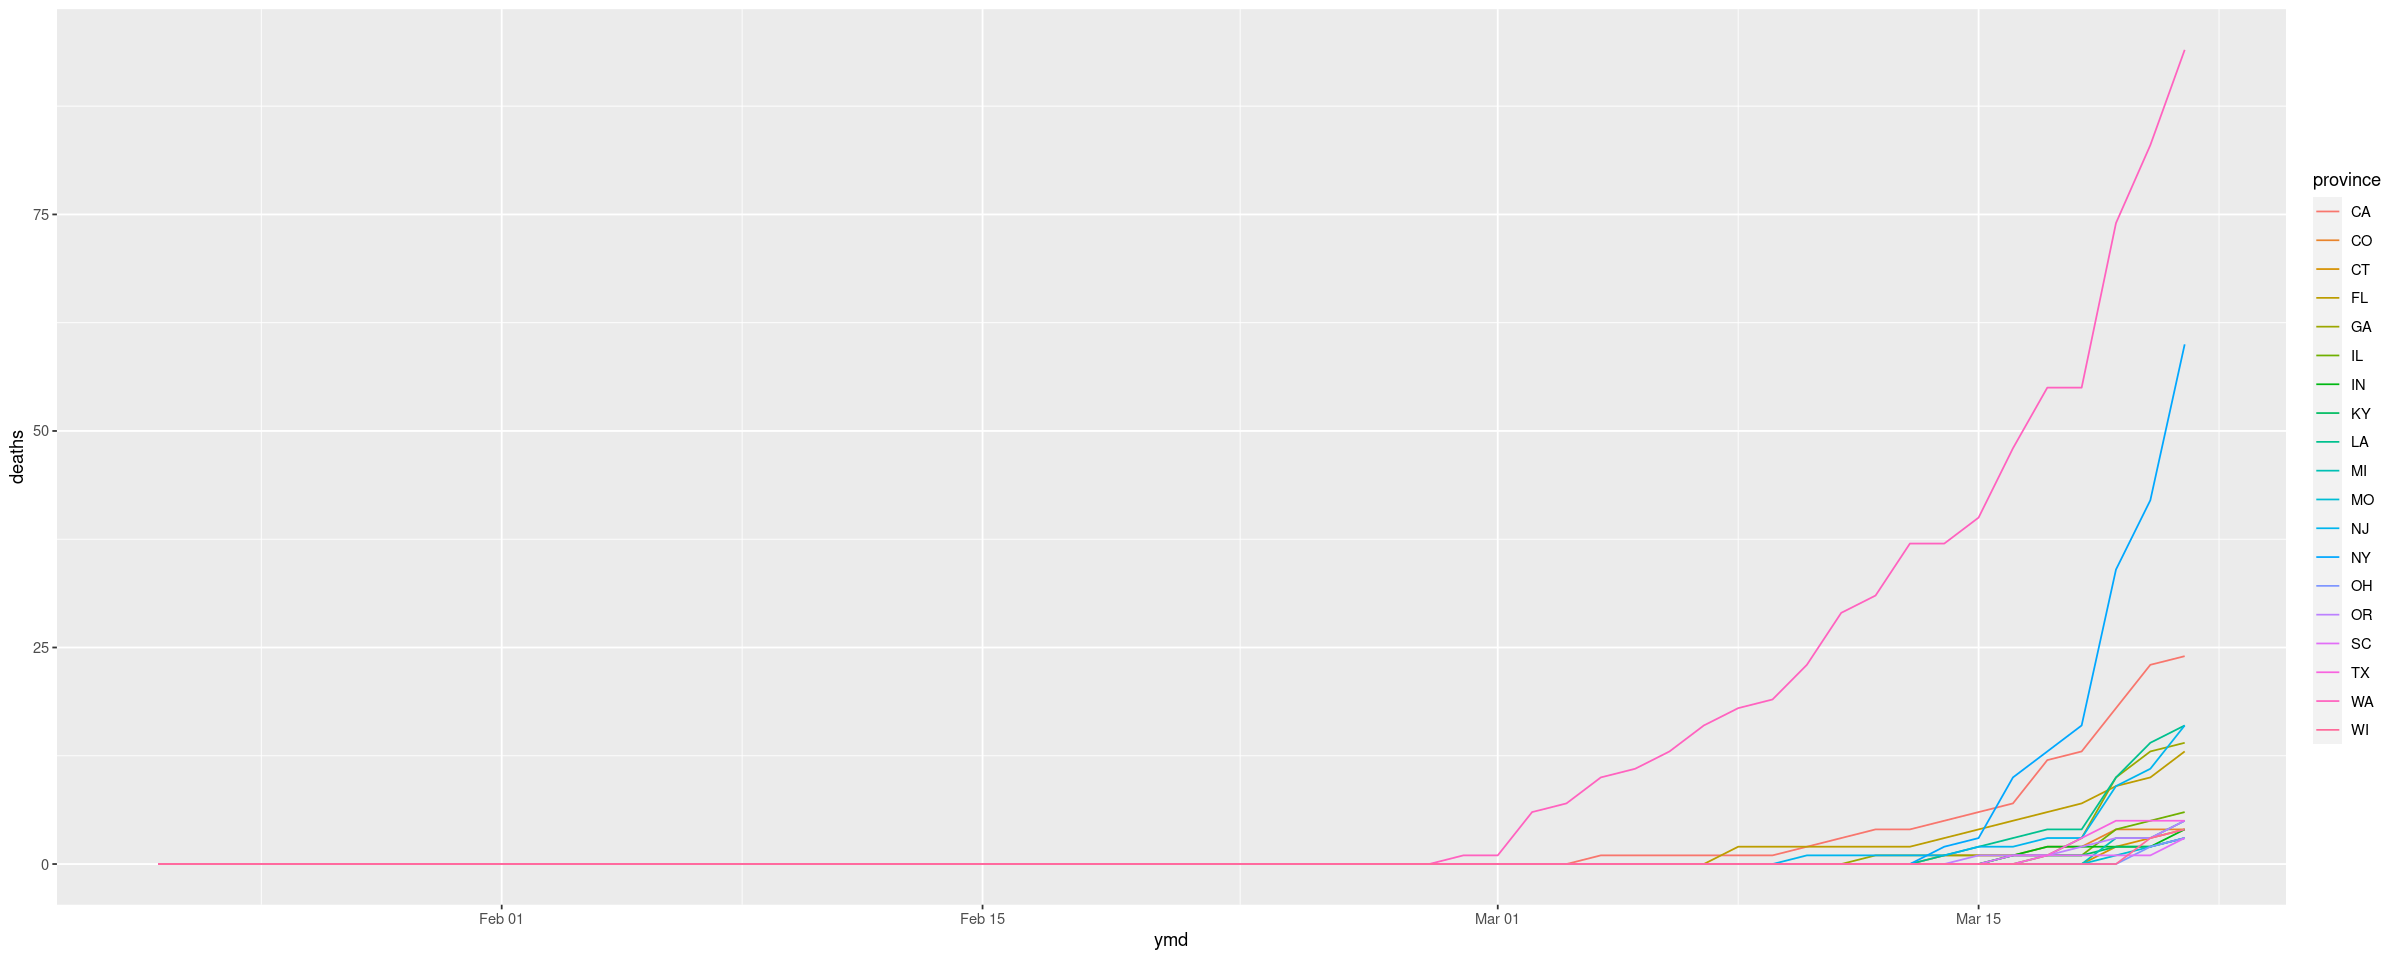

In [197]:
combined_df %>%
filter(region== "US") %>%
# tidyr::separate(col = province, into = c("city", "state"), sep = ",") %>%
group_by(province, ymd) %>%
summarise(deaths = sum(deaths)) %>%
group_by(province) %>%
mutate(max_val= max(deaths)) %>%
ungroup() %>%
arrange(desc(max_val)) %>%
mutate(rank= dense_rank(desc(max_val)))%>%
filter(rank < 15) %>%
filter(max_val >2) %>%
ggplot(aes(x=ymd, y= deaths, color=province)) +
geom_line()

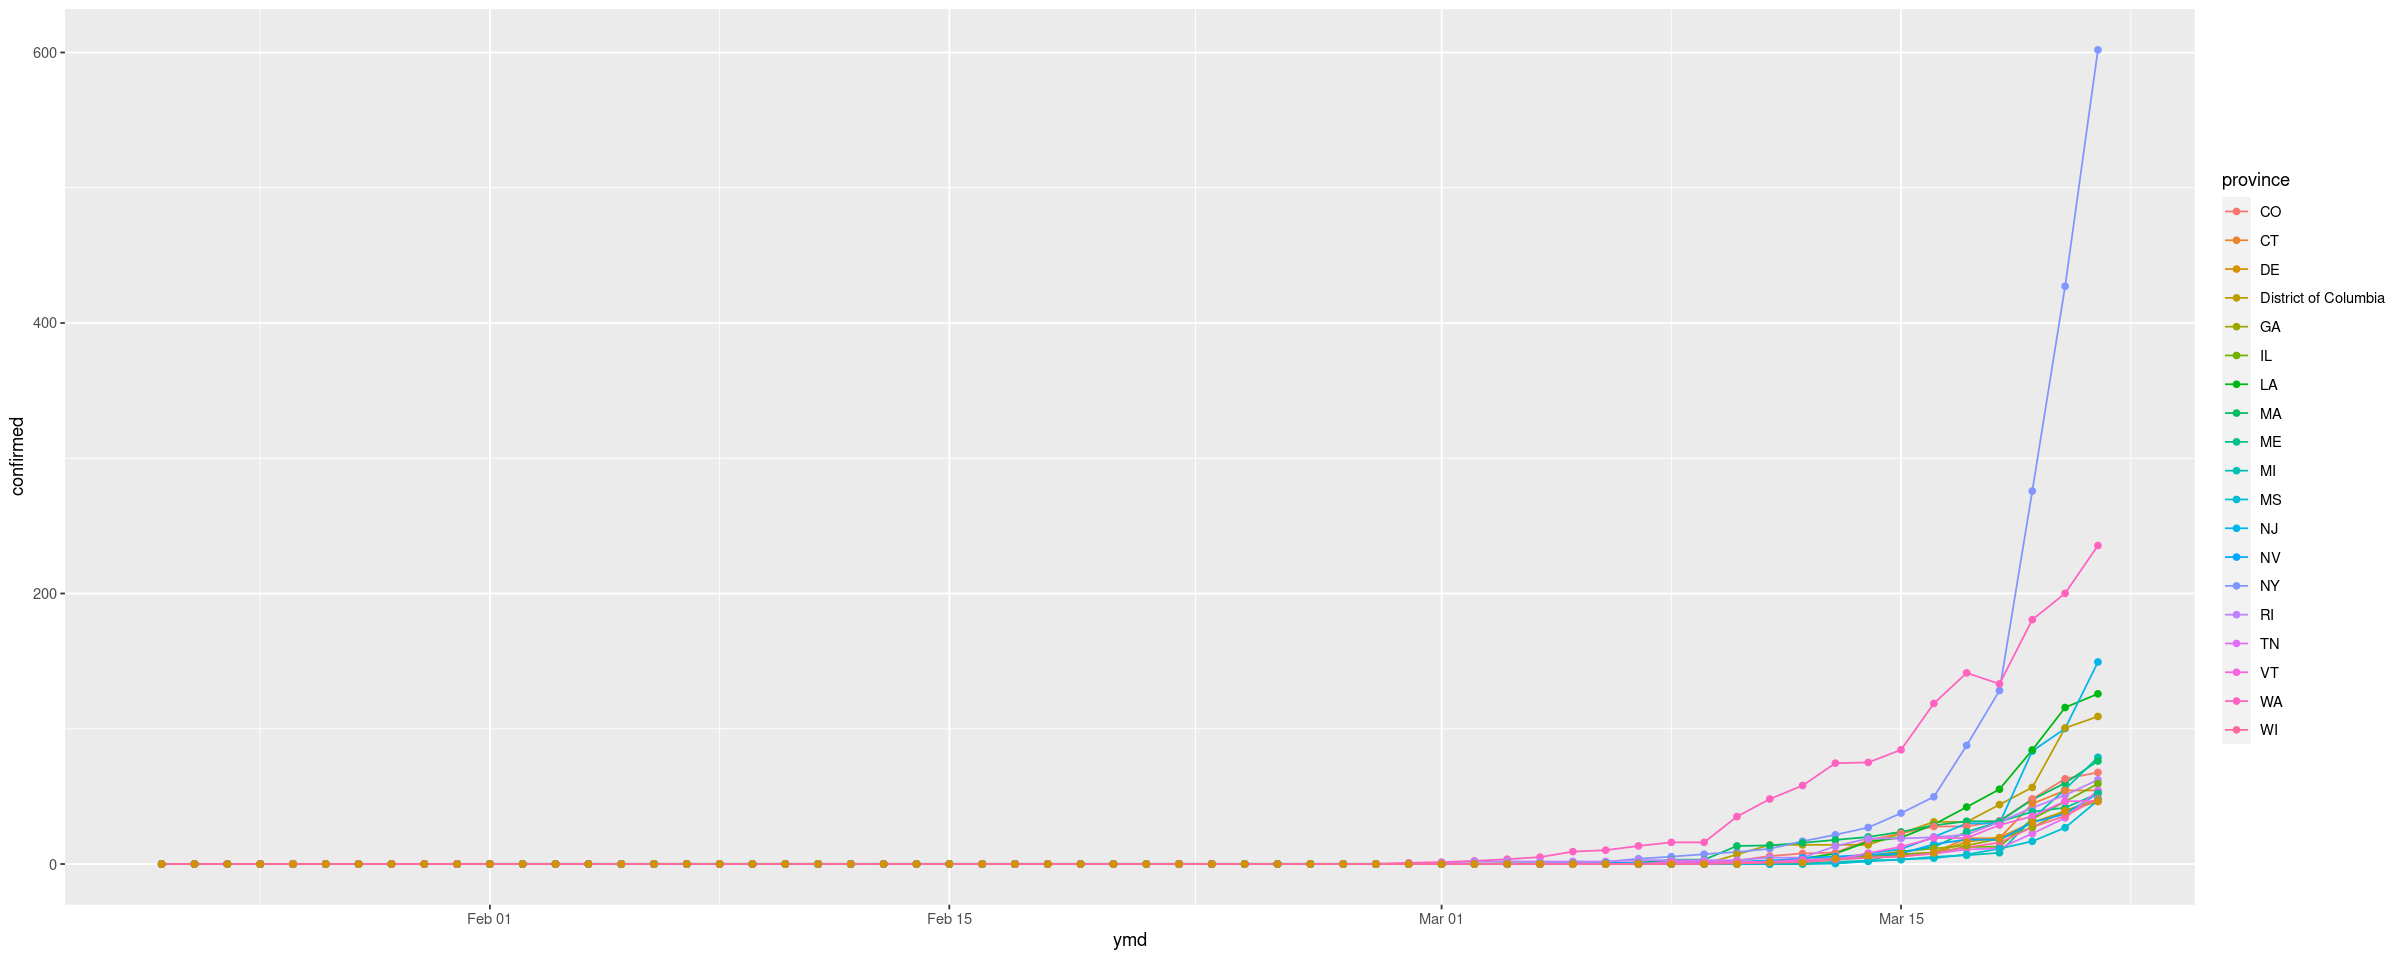

In [217]:
combined_df %>%
filter(region== "US") %>%
group_by(province, ymd) %>%
summarise(confirmed = sum(confirmed, na.rm = T)*1.0/first(pop/(10*10^5))) %>%
group_by(province) %>%
mutate(max_val= max(confirmed)) %>%
ungroup() %>%
arrange(desc(max_val)) %>%
mutate(rank= dense_rank(desc(max_val)))%>%
filter(rank < 20) %>%
filter(max_val >2) %>%
ggplot(aes(x=ymd, y= confirmed, color=province)) +
geom_line() +
geom_point()

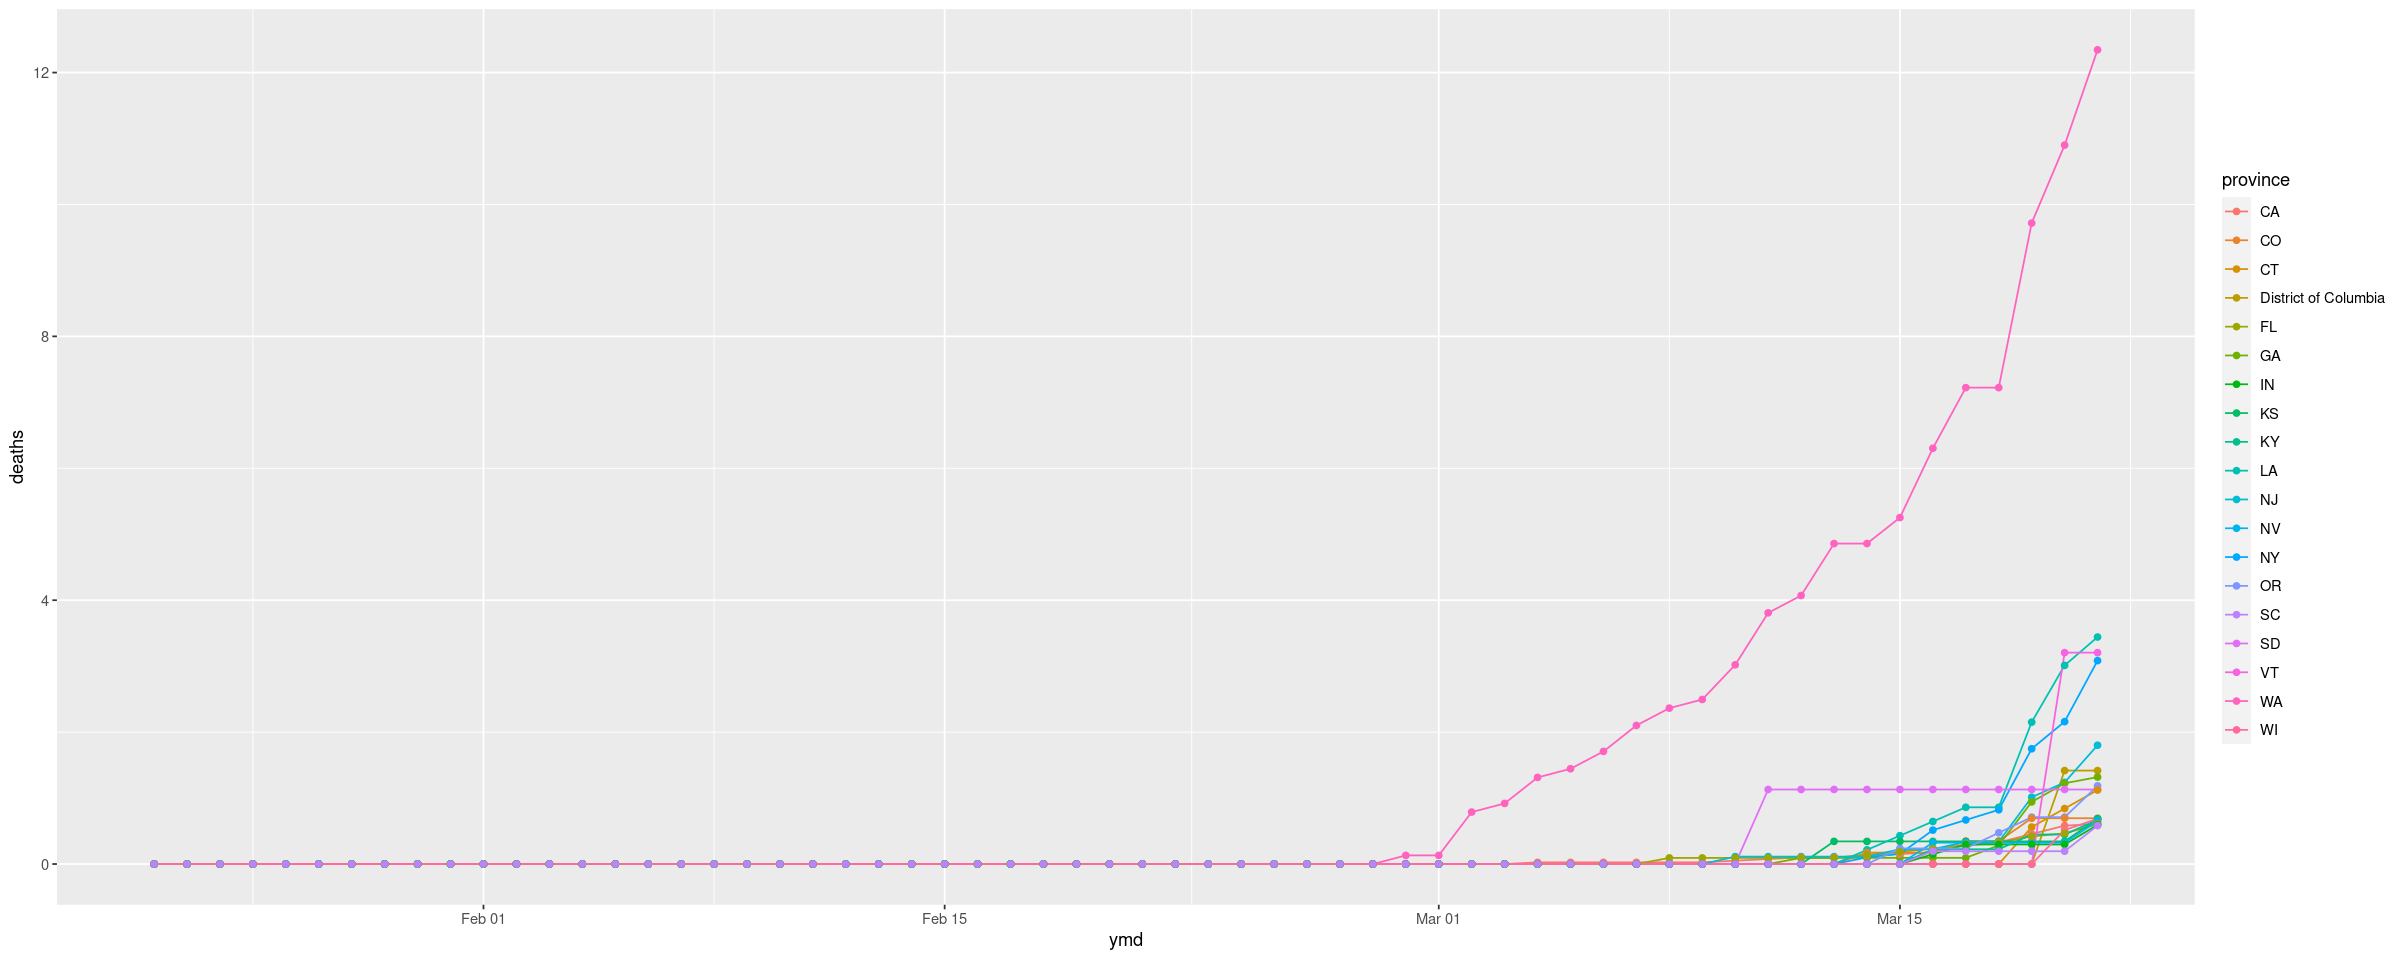

In [221]:
combined_df %>%
filter(region== "US") %>%
group_by(province, ymd) %>%
summarise(deaths = sum(deaths, na.rm = T)*1.0/first(pop/(10*10^5))) %>%
group_by(province) %>%
mutate(max_val= max(deaths)) %>%
ungroup() %>%
arrange(desc(max_val)) %>%
mutate(rank= dense_rank(desc(max_val)))%>%
filter(rank < 20) %>%
# filter(max_val >2) %>%
ggplot(aes(x=ymd, y= deaths, color=province)) +
geom_line() +
geom_point()

Warning message:
“Removed 19 row(s) containing missing values (geom_path).”
Warning message:
“Removed 19 rows containing missing values (geom_point).”


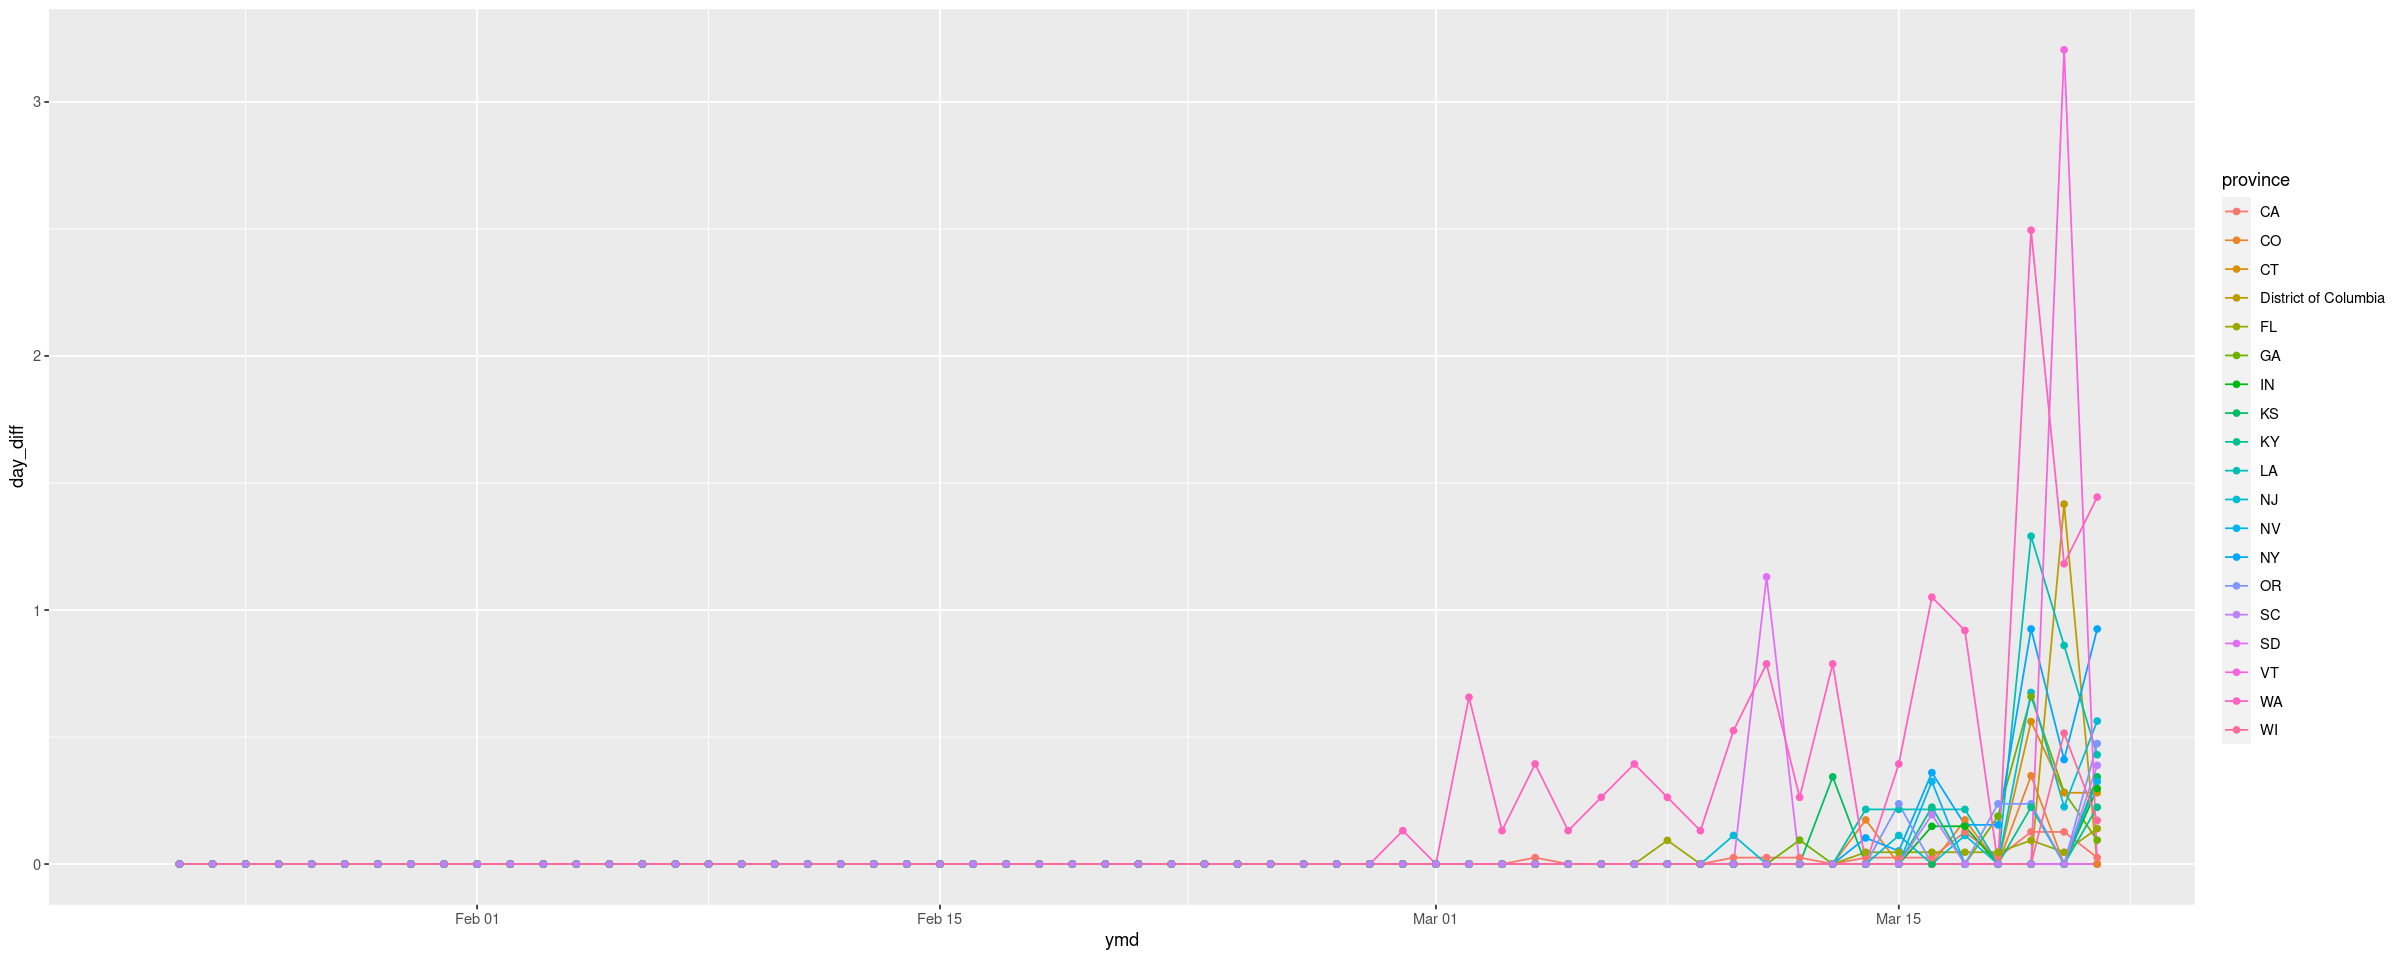

In [222]:
combined_df %>%
filter(region== "US") %>%
group_by(province, ymd) %>%
summarise(deaths = sum(deaths, na.rm = T)*1.0/first(pop/(10*10^5))) %>%
group_by(province) %>%
mutate(max_val= max(deaths),
      day_diff = deaths - lag(deaths)) %>%
ungroup() %>%
arrange(desc(max_val)) %>%
mutate(rank= dense_rank(desc(max_val)))%>%
filter(rank < 20) %>%
# filter(max_val >2) %>%
ggplot(aes(x=ymd, y= day_diff, color=province)) +
geom_line() +
geom_point()

In [220]:
combined_df %>% 
filter(region== "US") %>%
filter(province=="UT") %>%
tail(20)

,region,province,city,lat,long,ymd,deaths,recovered,confirmed,pop
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
221,US,UT,Utah,40.1500,-111.8624,2020-03-17,0,0,51,3205958
222,US,UT,Weber,41.2603,-111.9522,2020-03-17,0,0,0,3205958
223,US,UT,Davis County,40.9629,-112.0953,2020-03-17,0,0,0,3205958
224,US,UT,Summit,40.8298,-110.9984,2020-03-17,0,0,0,3205958
225,US,UT,Utah,40.1500,-111.8624,2020-03-18,0,0,51,3205958
226,US,UT,Weber,41.2603,-111.9522,2020-03-18,0,0,0,3205958
227,US,UT,Davis County,40.9629,-112.0953,2020-03-18,0,0,0,3205958
228,US,UT,Summit,40.8298,-110.9984,2020-03-18,0,0,0,3205958
229,US,UT,Utah,40.1500,-111.8624,2020-03-19,0,0,80,3205958
